In [2]:
import pandas as pd
import json

import matplotlib.pyplot as plt

In [3]:
with open('squats_03.json', 'r') as json_file:
    data = json.load(json_file)

In [4]:
data = pd.json_normalize(data)

In [5]:
data.head()

,accuracy,data,experimentId,patientId,sensorId,sensorType,timestamp
0,3,"[0.13998012, 4.959424, 9.529716]",0,0,LSM6DSO Accelerometer,1,3114357777961892
1,3,"[-0.2661767, -0.6666634, -0.59076566]",0,0,LSM6DSO Gyroscope,4,3114357785170433
2,3,"[-0.009571291, 4.7727838, 9.969097]",0,0,LSM6DSO Accelerometer,1,3114357758545121
3,3,"[-0.09332009, 4.694718, 10.000204]",0,0,LSM6DSO Accelerometer,1,3114357739128454
4,3,"[-0.28236416, -0.66849595, -0.5803813]",0,0,LSM6DSO Gyroscope,4,3114357804587308


sensorId
LSM6DSO Accelerometer                 666
LSM6DSO Gyroscope                     663
LSM6DSO Gyroscope-Uncalibrated         63
LSM6DSO Accelerometer-Uncalibrated     63
linear_acceleration                    62
Name: count, dtype: int64


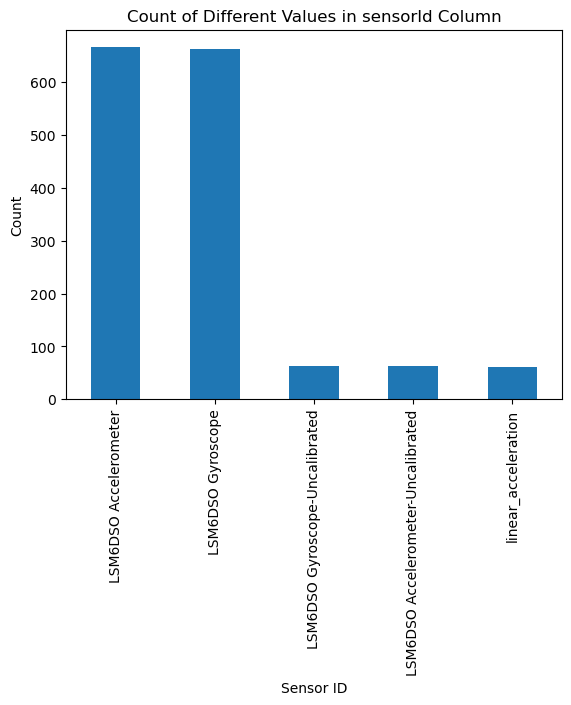

In [6]:
sensor_counts = data['sensorId'].value_counts()

# Print the sensor counts (optional)
print(sensor_counts)

# Plot the sensor counts
sensor_counts.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Sensor ID')
plt.ylabel('Count')
plt.title('Count of Different Values in sensorId Column')

# Show the plot
plt.show()



In [7]:
# Filter the DataFrame for 'icm4x6xx Accelerometer Non-wakeup' in the 'sensorType' column
df = data[data['sensorId'] == 'LSM6DSO Accelerometer']

df.head()

,accuracy,data,experimentId,patientId,sensorId,sensorType,timestamp
0,3,"[0.13998012, 4.959424, 9.529716]",0,0,LSM6DSO Accelerometer,1,3114357777961892
2,3,"[-0.009571291, 4.7727838, 9.969097]",0,0,LSM6DSO Accelerometer,1,3114357758545121
3,3,"[-0.09332009, 4.694718, 10.000204]",0,0,LSM6DSO Accelerometer,1,3114357739128454
5,3,"[0.16031912, 4.8708897, 8.889337]",0,0,LSM6DSO Accelerometer,1,3114357797378871
8,3,"[0.18185452, 4.453043, 8.773284]",0,0,LSM6DSO Accelerometer,1,3114357855629340


C:\Users\aiskr\AppData\Local\Temp\ipykernel_22464\2703582743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Users\aiskr\AppData\Local\Temp\ipykernel_22464\2703582743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'z']] = pd.DataFrame(df['data'].tolist(), index=df.index)
C:\Users\aiskr\AppData\Local\Temp\ipykernel_22464\2703582743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

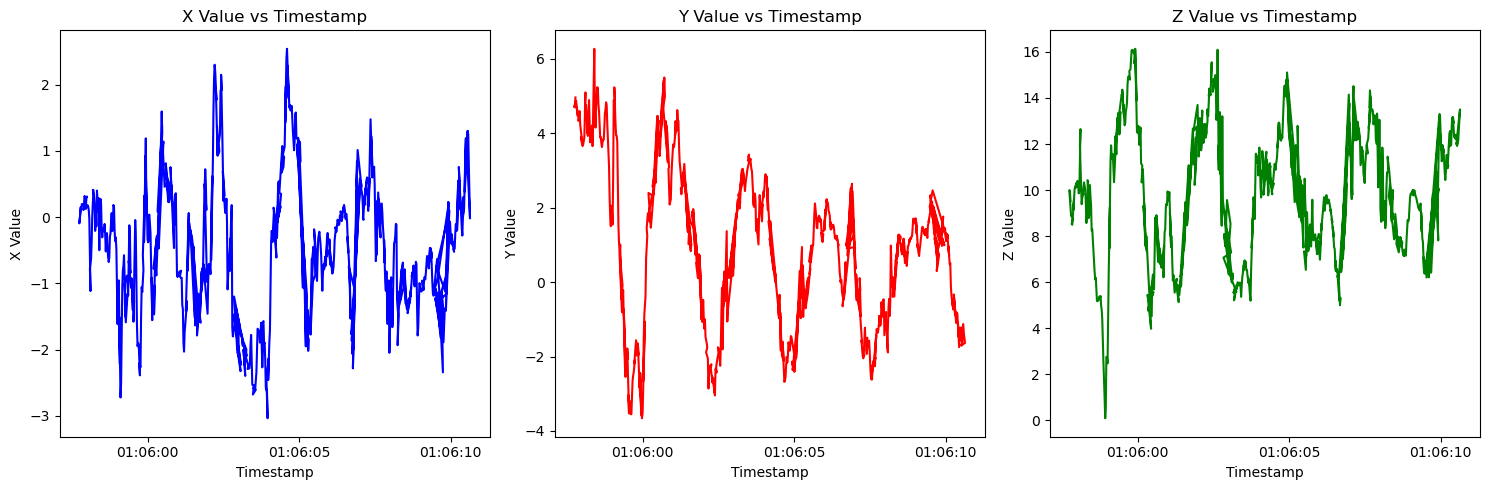

In [8]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract 'x', 'y', 'z' values from the 'data' column
df[['x', 'y', 'z']] = pd.DataFrame(df['data'].tolist(), index=df.index)

# Create df_sensor with the desired columns
df_sensor = df[['timestamp', 'x', 'y', 'z']]

# Create a 1x3 grid for the plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 'x' values
axs[0].plot(df_sensor['timestamp'], df_sensor['x'], linestyle='-', color='b')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('X Value')
axs[0].set_title('X Value vs Timestamp')

# Plot 'y' values
axs[1].plot(df_sensor['timestamp'], df_sensor['y'], linestyle='-', color='r')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Y Value')
axs[1].set_title('Y Value vs Timestamp')

# Plot 'z' values
axs[2].plot(df_sensor['timestamp'], df_sensor['z'], linestyle='-', color='g')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Z Value')
axs[2].set_title('Z Value vs Timestamp')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Z axis will be taken for further analysis. Below an attempt for a simple squad detection

c:\Users\aiskr\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


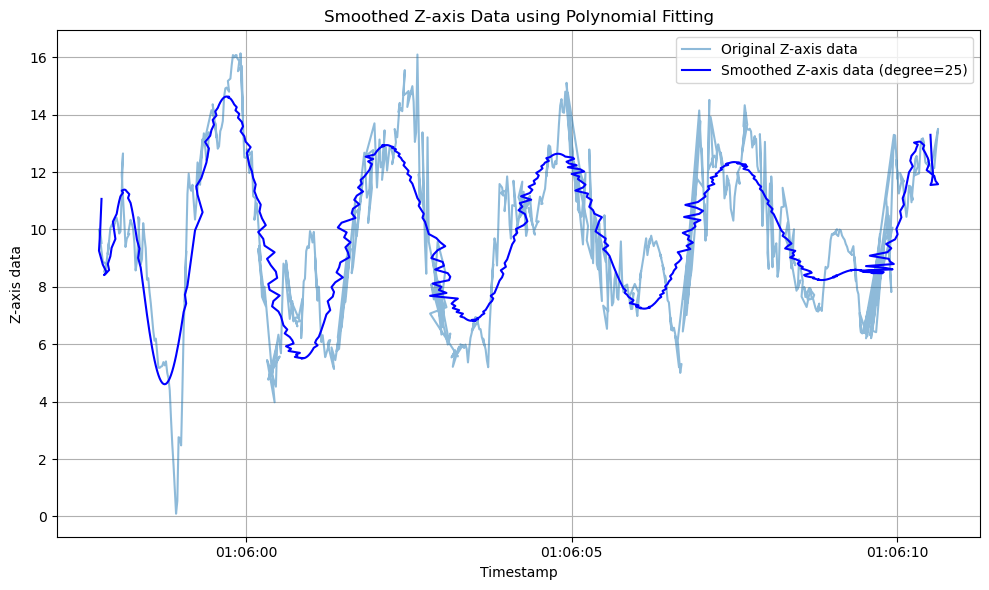

In [71]:
import pandas as pd
import numpy as np

z_data = df_sensor['z']
timestamps = df_sensor['timestamp']
# Example data (replace with your actual data)
x = np.arange(len(z_data))  # Assuming timestamps or index as x-axis
y = z_data.values  # Assuming z-axis data as y-axis

# Fit a 3rd-degree polynomial curve (adjust degree as needed)
degree = 25
coefficients = np.polyfit(x, y, degree)
poly_function = np.poly1d(coefficients)

# Evaluate polynomial function over the range of x
smoothed_y = poly_function(x)

# Plotting the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(timestamps, z_data, label='Original Z-axis data', alpha=0.5)  # Original data with transparency
plt.plot(timestamps, smoothed_y, label=f'Smoothed Z-axis data (degree={degree})', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Z-axis data')
plt.title('Smoothed Z-axis Data using Polynomial Fitting')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Total number of squats detected: 49


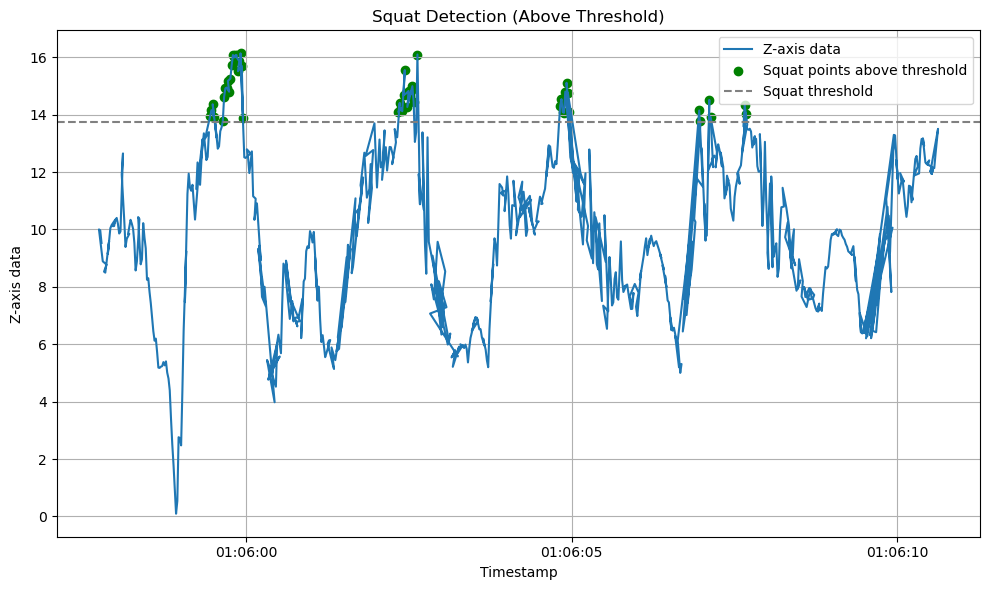

In [55]:
# Assuming df_sensor['z'] contains your z-axis data and df_sensor['timestamp'] contains timestamps

z_mean = z_data.mean()
squat_threshold = z_mean +4 # Adjusted threshold for points above the mean

squat_count = 0
in_squat = False
squat_indices = []

for i, z in enumerate(z_data):
    if z > squat_threshold:
        in_squat = True
        squat_count += 1
        squat_indices.append(i)  # Store the index of squat point
    elif z <= squat_threshold:
        in_squat = False

print(f'Total number of squats detected: {squat_count}')

# Plotting the z_data with squat points marked
plt.figure(figsize=(10, 6))
plt.plot(timestamps, z_data, label='Z-axis data')
plt.scatter(timestamps.iloc[squat_indices], z_data.iloc[squat_indices], color='green', marker='o', label='Squat points above threshold')
plt.axhline(y=squat_threshold, color='gray', linestyle='--', label='Squat threshold')
plt.xlabel('Timestamp')
plt.ylabel('Z-axis data')
plt.title('Squat Detection (Above Threshold)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()